In [ ]:
import os
import re
import git
import sys
import glob
import json
import joblib
import sklearn
import skimage
import shutil
import tifffile
import imageio
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib

import matplotlib
from matplotlib import pyplot as plt

In [ ]:
import IPython
from matplotlib import rcParams

IPython.display.set_matplotlib_formats('png2x')

rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = (8, 6)
rcParams['font.family'] = 'sans-serif'

In [ ]:
from dragonfly_automation import microscope_operations, utils
from dragonfly_automation.tests.mocks import mm2python_mocks
from dragonfly_automation.settings_schemas import StackSettings
from dragonfly_automation.fov_models import PipelineFOVScorer
from dragonfly_automation.acquisitions import pipeline_plate_settings
%load_ext autoreload
%autoreload 2

### Develop tests

In [ ]:
interface = mm2python_mocks.get_mocked_interface(channel='488', exposure_state='way-over')
interface.create_datastore('../tests/output/dummy/dir')

def event_logger(event):
    print(event)

stack_settings = StackSettings(
    stage_label='label', relative_bottom=0, relative_top=3, step_size=1
)

In [ ]:
microscope_operations.autoexposure(
    interface,
    pipeline_plate_settings.fluorescence_stack_settings,
    pipeline_plate_settings.autoexposure_settings,
    pipeline_plate_settings.gfp_channel_settings,
    event_logger
)

In [ ]:
interface = mm2python_mocks.get_mocked_interface(afc_fail_on_first_n_calls=3)
interface.mm_core._current_z_position = 123
microscope_operations.call_afc(interface, event_logger)

### MM 2.0 gamma API

In [ ]:
import pycromanager
bridge = pycromanager.Bridge(convert_camel_case=False)
mm_core = bridge.get_core()
mm_studio = bridge.get_studio()

In [ ]:
position_list = mm_studio.getPositionListManager().getPositionList()
pos = position_list.getPosition(ind)
pos.goToPosition(pos, mm_core)

In [ ]:
af_plugin = mm_studio.getAutofocusManager().getAutofocusMethod()
af_plugin.fullFocus()

In [ ]:
mm_core.setPosition('', 123)

In [ ]:
mm_core.getPosition()

In [ ]:
result.size()

In [ ]:
mm_core.getPosition('DStage')

### Manually select FOVs from existing datasets

In [ ]:
fov_scorer = PipelineFOVScorer(save_dir='../models/2019-10-08/', mode='prediction', random_state=42)
fov_scorer.load()
fov_scorer.train()
fov_scorer.validate()

In [ ]:
# PML0216 had progressively less clumpiness, with some too-few and no-nuclei FOVs
pml_dir = pathlib.Path('/Volumes/ml_group/raw-pipeline-microscopy/PML0216/')

# PML0316 was a very good full-plate
pml_dir = pathlib.Path('/Volumes/ml_group/raw-pipeline-microscopy/PML0316/')

In [ ]:
snaps_dir = pml_dir / 'logs/fov-scoring/fov-images/'

df = pd.read_csv(pml_dir / 'logs/fov-scoring/fov-score-log.csv')

scored = df.loc[df.score.notna()]
too_few = df.loc[df.comment == 'Too few nuclei in the FOV']
no_nuclei = df.loc[df.comment == 'No nuclei in the FOV']

scored = scored.sort_values(by='score', ascending=False)

In [ ]:
scored.shape, too_few.shape, no_nuclei.shape

In [ ]:
row = too_few.iloc[0]
filepath = snaps_dir / f'FOV_{row.position_name}_RAW.tif'
im = imageio.imread(filepath)
plt.imshow(im)

result = fov_scorer.score_raw_fov(im, min_otsu_thresh=700, min_num_nuclei=10)
row.score, result.get('score'), result.get('comment')

In [ ]:
dst_dirpath = '/Users/keith.cheveralls/projects/dragonfly-automation/dragonfly_automation/tests/artifacts/snaps/'
# shutil.copy2(filepath, os.path.join(dst_dirpath, 'too-few-1.tif'))


In [ ]:
results = []
for filepath in sorted(glob.glob('%s/*.tif' % dst_dirpath)):
    results.append(fov_scorer.process_existing_fov(filepath))

In [ ]:
im = imageio.imread(os.path.join(dst_dirpath, 'good-2.tif'))
np.percentile(im.flatten(), 99)

### Parse all-events log

In [261]:
shutil.copy2(
    '%s/logs/all-events.log' % pml_dir, 
     '/Users/keith.cheveralls/image-data/PML0316-all-events.log'
)

'/Users/keith.cheveralls/image-data/PML0316-all-events.log'

In [262]:
with open('/Users/keith.cheveralls/image-data/PML0316-all-events.log', 'r') as file:
    lines = file.readlines()
len(lines)

2046881

In [291]:
commands = []
for line in lines:
    result = re.findall('.+ MM2PYTHON: JavaObject.(\w+)', line)
    if result:
        command = result[0]
    commands.append(command)

In [ ]:
np.array(sorted(set(commands)))

In [ ]:
pd.Series(commands).value_counts()

### Concat logs from all PMLs

In [183]:
pml_dirs = sorted(glob.glob('/Volumes/ml_group/raw-pipeline-microscopy/PML*'))
len(pml_dirs)

136

In [184]:
def concat_csv_logs(rel_filepath, sep=','):
    logs = []
    for pml_dir in pml_dirs:    
        filepath = os.path.join(pml_dir, rel_filepath)
        if not os.path.exists(filepath):
            continue
        log = pd.read_csv(filepath, sep=sep, header=[0])
        log['pml_id'] = pml_dir.split(os.sep)[-1]
        logs.append(log)

    df = pd.concat(tuple(logs), axis=0)
    df.columns = ['event', 'pml_id']
    return df

In [ ]:
all_fov_logs = concat_csv_logs('logs/fov-scoring/fov-score-log.csv')

In [89]:
all_afc_logs = concat_csv_logs('logs/afc-calls.csv')

In [93]:
all_aq_logs = concat_csv_logs('logs/acquired-images.csv')

In [131]:
all_fov_logs.shape, all_afc_logs.shape, all_aq_logs.shape

((195946, 18), (172261, 10), (39449, 17))

In [185]:
def concat_logs(rel_filepath, sep=','):
    lines = []
    for pml_dir in pml_dirs:    
        filepath = os.path.join(pml_dir, rel_filepath)
        if not os.path.exists(filepath):
            continue
        with open(filepath, 'r') as file:
            lines.extend(file.readlines())
    return lines

In [186]:
all_ev_log_lines = concat_logs('logs/important-events.log', sep='\n')

In [187]:
len(all_ev_log_lines)

657112

In [194]:
all_ev_logs = pd.DataFrame(
    data=[line.strip() for line in all_ev_log_lines if line != '\n']
)
all_ev_logs.columns = ['event']

In [ ]:
all_ev_logs['date'] = all_ev_logs.event.str.slice(0, 10)
all_ev_logs['message'] = all_ev_logs.event.str.slice(20)
all_ev_logs['kind'] = all_ev_logs.message.apply(lambda s: s.split(':')[0])

In [251]:
# observed event categories (determined empirically, not by code inspection)
valid_kinds = [
    'AUTOFOCUS INFO', 
    'AUTOFOCUS ERROR',
    'AUTOEXPOSURE INFO', 
    'AUTOEXPOSURE ERROR',
    'ACQUISITION INFO', 
    'ACQUISITION WARNING', 
    'ACQUISITION ERROR', 
    'SCORING INFO', 
    'SCORING WARNING', 
    'SCORING ERROR', 
    'ERROR',
    'FATAL ERROR'
]
all_ev_logs = all_ev_logs.loc[all_ev_logs.kind.isin(valid_kinds)]

In [ ]:
# counts of event kind by date
all_ev_logs.loc[all_ev_logs.kind.str.contains('ERROR')].groupby(['kind', 'date']).count()

In [ ]:
all_ev_logs.loc[all_ev_logs.kind == 'ERROR']

In [204]:
all_ev_logs['flag'] = all_ev_logs.event.str.contains('ERROR')

In [205]:
all_ev_logs.loc[all_ev_logs.flag].kind.value_counts().head(22)

AUTOFOCUS ERROR       374
ERROR                 189
SCORING ERROR          15
ACQUISITION ERROR       6
AUTOEXPOSURE ERROR      5
FATAL ERROR             2
Name: kind, dtype: int64

In [214]:
all_ev_logs.loc[all_ev_logs.kind == 'ERROR'].to_csv('~/all-error-events.csv')

In [ ]:
all_fov_logs.comment.value_counts()

In [237]:
all_afc_logs.head()

,timestamp,initial_afc_score,final_afc_score,final_focusdrive_position,initial_focusdrive_position,last_afc_error_message,failed_offsets,afc_did_succeed,position_ind,pml_id
0,2020-06-04 10:23:45,-23.8652,-0.6357,6195.411345,6197.374725,NaN,[],True,0,PML0303
1,2020-06-04 10:23:47,-21.4209,-0.5039,6195.411345,6195.411345,NaN,[],True,0,PML0303
2,2020-06-04 10:23:50,-2.8232,1.6592,6197.112180,6195.411345,NaN,[],True,1,PML0303
3,2020-06-04 10:23:53,14.4785,1.5137,6198.261290,6197.112180,NaN,[],True,2,PML0303
4,2020-06-04 10:23:56,19.7539,0.8857,6199.288640,6198.261290,NaN,[],True,3,PML0303


In [229]:
all_afc_logs.failed_offsets.value_counts()

[]                          170847
[0]                            587
[0, 10, 20, 40, -20]           338
[0, 10]                        237
[0, 10, 20]                    184
[0, 10, 20, 40, 60, -20]        36
[0, 10, 20, 40]                 30
[0, 10, 20, 40, 60]              2
Name: failed_offsets, dtype: int64

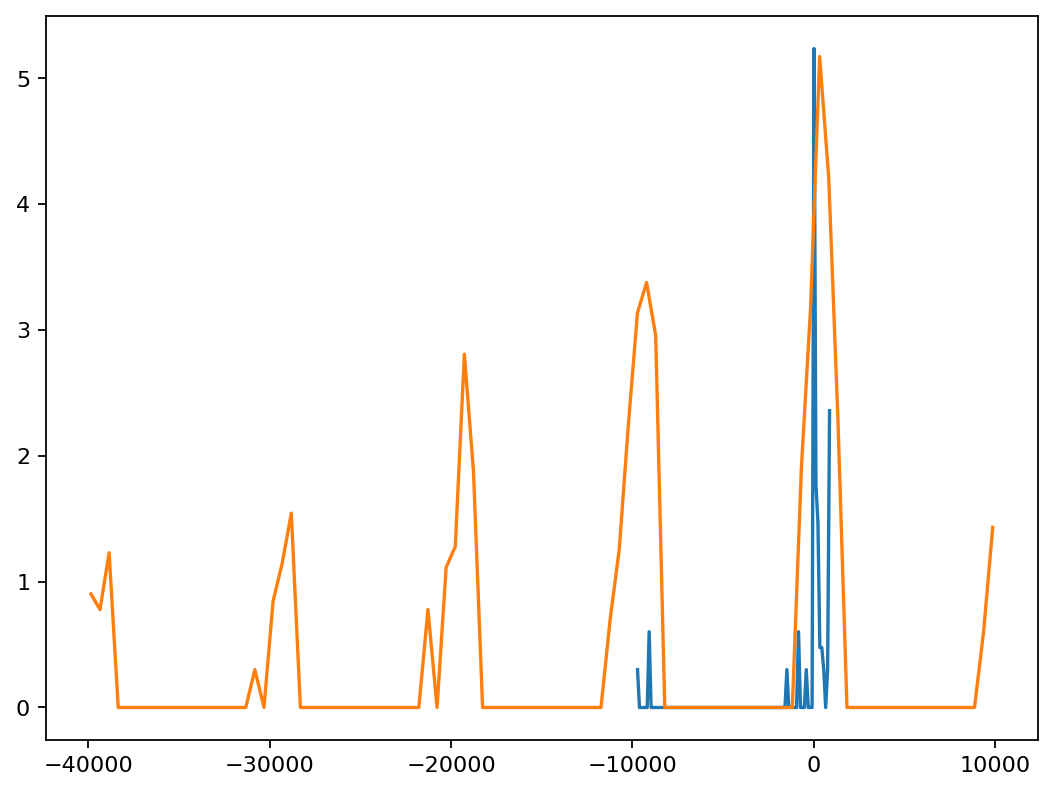

In [308]:
counts, edges = np.histogram(all_afc_logs.final_afc_score, bins=100)
plt.plot(edges[1:], np.log10(counts + 1))

counts, edges = np.histogram(all_afc_logs.initial_afc_score, bins=100)
plt.plot(edges[1:], np.log10(counts + 1))

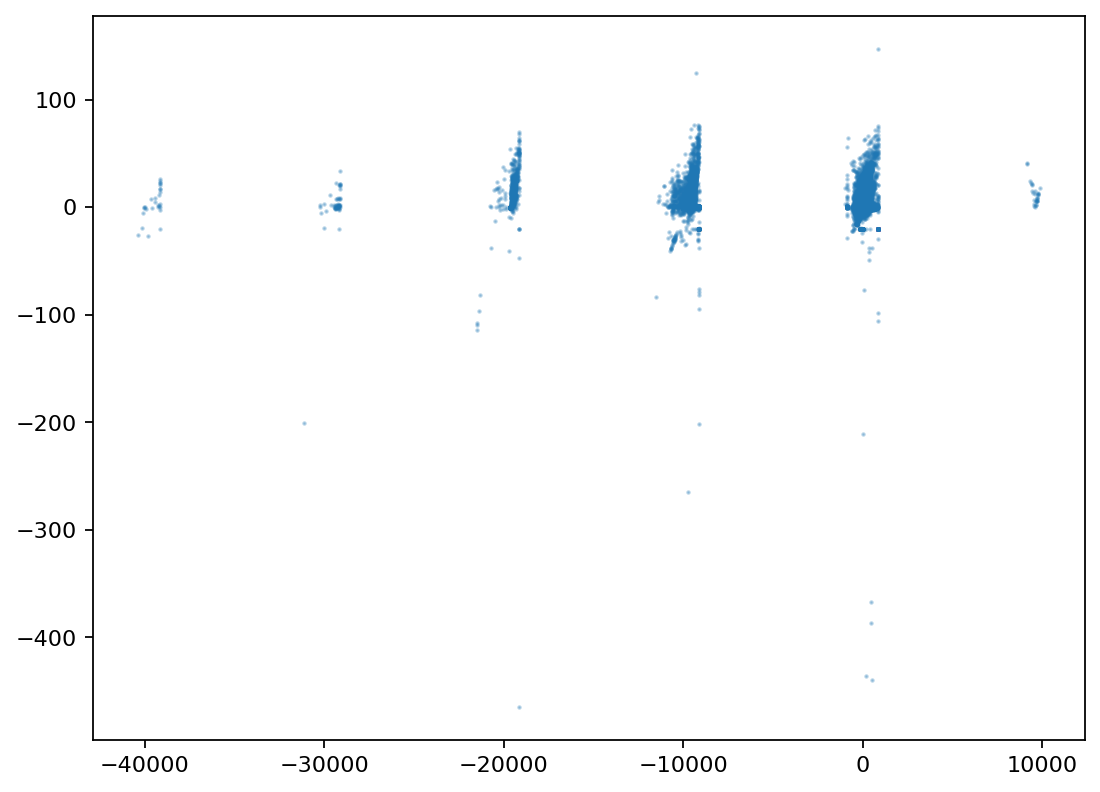

In [310]:
_ = plt.scatter(
    all_afc_logs.initial_afc_score,
    all_afc_logs.final_focusdrive_position - all_afc_logs.initial_focusdrive_position, 
    alpha=0.3,
    s=1
)

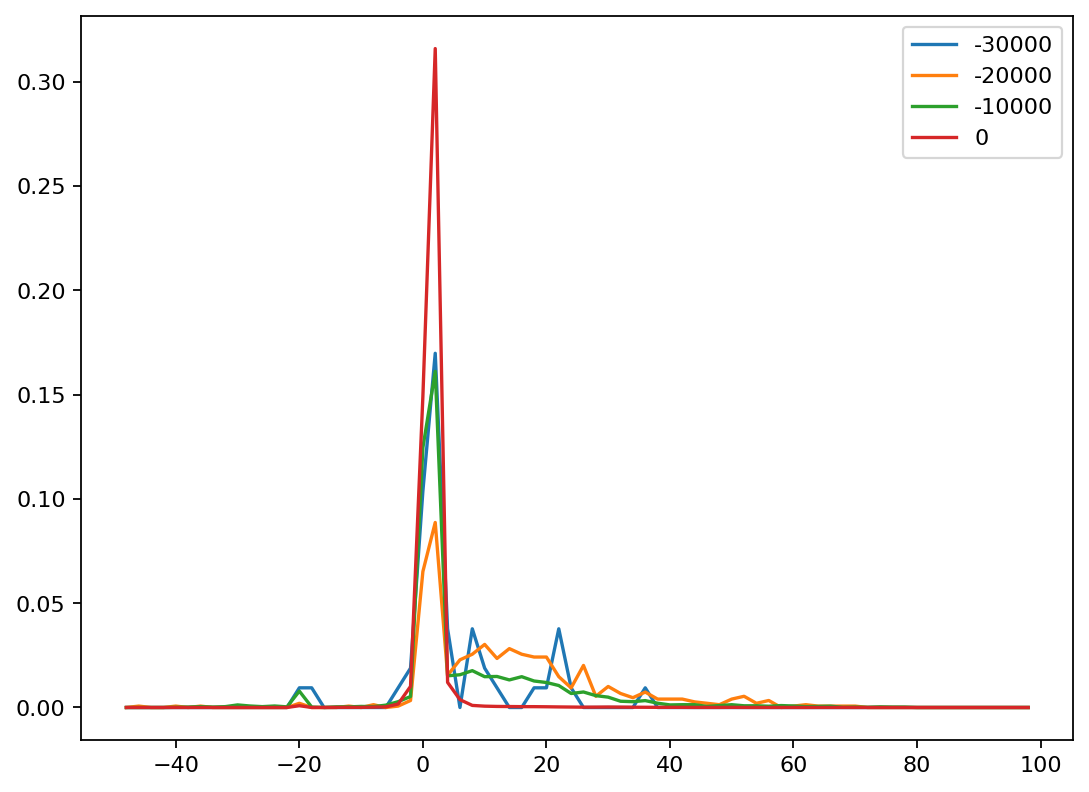

In [321]:
width = 10000
cens = [-30000, -20000, -10000, 0]

for cen in cens:
    mask = (
        (all_afc_logs.initial_afc_score > (cen - width/2)) & 
        (all_afc_logs.initial_afc_score < (cen + width/2))
    )
    counts, edges = np.histogram(
        all_afc_logs.loc[mask].final_focusdrive_position - all_afc_logs.loc[mask].initial_focusdrive_position, 
         bins=np.arange(-50, 100, 2),
        density=True
    )
    y = counts #np.log10(counts + 1)
    plt.plot(edges[1:], y, label=cen) #np.log10(counts + 1))
plt.legend()

In [333]:
def count_failed_offsets(cen, width=10000):
    mask = (
        (all_afc_logs.initial_afc_score > (cen - width/2)) & 
        (all_afc_logs.initial_afc_score < (cen + width/2))
    )
    counts = all_afc_logs.loc[mask].failed_offsets.value_counts()
    return 100*counts / counts.sum()

In [334]:
count_failed_offsets(cen=0)

[]                          99.520870
[0]                          0.202339
[0, 10, 20, 40, -20]         0.157909
[0, 10]                      0.055238
[0, 10, 20]                  0.043230
[0, 10, 20, 40, 60, -20]     0.016211
[0, 10, 20, 40]              0.003602
[0, 10, 20, 40, 60]          0.000600
Name: failed_offsets, dtype: float64

In [335]:
count_failed_offsets(cen=-10000)

[]                          90.470297
[0]                          4.372937
[0, 10]                      1.608911
[0, 10, 20]                  1.526403
[0, 10, 20, 40, -20]         1.526403
[0, 10, 20, 40]              0.391914
[0, 10, 20, 40, 60, -20]     0.082508
[0, 10, 20, 40, 60]          0.020627
Name: failed_offsets, dtype: float64

In [336]:
count_failed_offsets(cen=-20000)

[]                          86.266667
[0, 10]                      5.466667
[0, 10, 20]                  4.400000
[0]                          2.666667
[0, 10, 20, 40]              0.666667
[0, 10, 20, 40, 60, -20]     0.400000
[0, 10, 20, 40, -20]         0.133333
Name: failed_offsets, dtype: float64

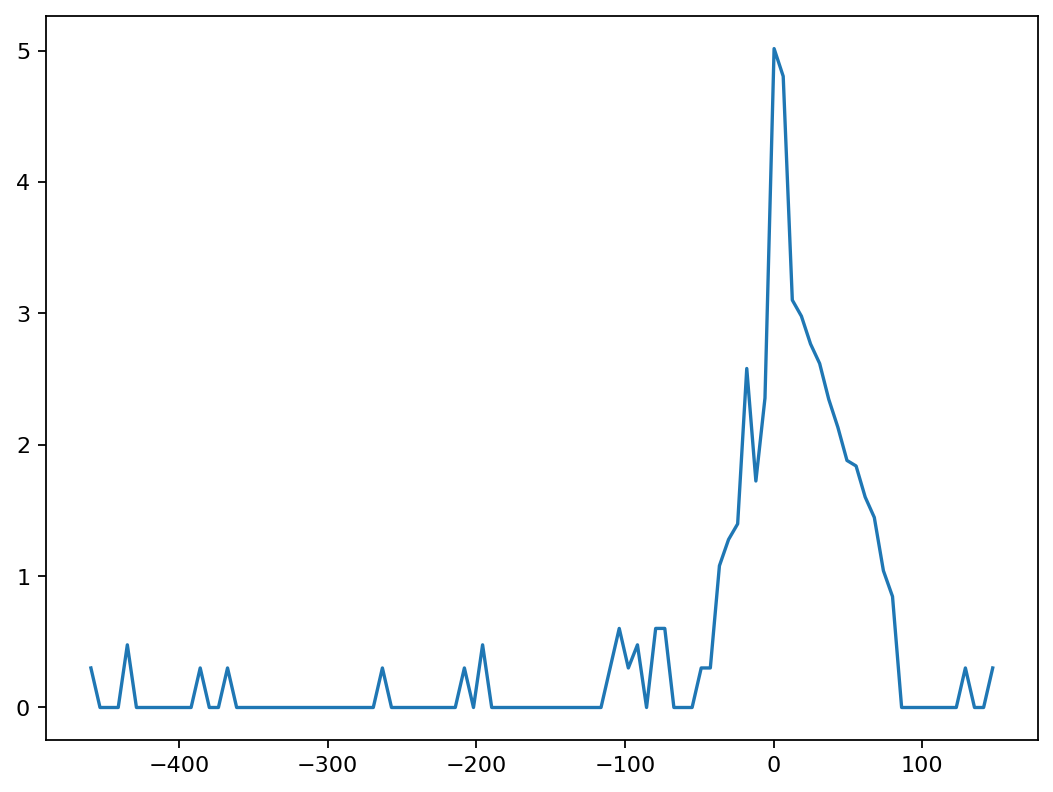

In [316]:
counts, edges = np.histogram(
    all_afc_logs.final_focusdrive_position - all_afc_logs.initial_focusdrive_position, 
     bins=100
)
plt.plot(edges[1:], np.log10(counts + 1))

In [ ]:
_ = plt.hist(all_fov_logs.num_nuclei, bins=np.arange(0, 200))